In [1]:
# using IJulia
# IJulia.installkernel("Julia 8 Threads", env=Dict(         #use this code if you don't have carmel which can use 8 Threads
#     "JULIA_NUM_THREADS" => "8",))                         #change carmel to which can use more Threads like Julia 8 Threads

In [2]:
Threads.nthreads()   #check how many Threads do you use 

8

In [3]:
using Agents , Random , InteractiveDynamics , CairoMakie 
using DrWatson: @dict
using DataFrames , Plots


mutable struct Agent2 <: AbstractAgent
    id::Int
    pos::NTuple{2,Float64}
    vel::NTuple{2,Float64}
    mass::Float64
    days_infected::Int # how many days have passed after infection
    status::Symbol # :S (susceptlibe), :I (infecious), :R (removed, immune), :Q (quarantine and infecious) 
    days_quarantine::Int
    hygiene::Float64
end


function symulation(;
    infection_period = 30 ,
    detection_time = 14 ,
    reinfection_probability = 0.01,
    isolated = 0.0, # 0 is nobady is isolated , 1 evryone is isolated
    interaction_radius = 0.012,
    dt = 1,
    speed = 0.002,
    death_rate = 0.044,
    N = 1000,
    initial_infected = 5,
    seed = 1410,
    hygiene_min = 0.4,
    hygiene_max = 0.8,
    time_of_quarantine = 10,
    steps_per_day = 12,
    chance_to_go_quaratine = 0.5
    )

    infection_period *= steps_per_day
    detection_time *=  steps_per_day
    time_of_quarantine *= steps_per_day

    properties = @dict(
        infection_period,
        detection_time,
        reinfection_probability,
        death_rate,
        dt,
        interaction_radius,
        time_of_quarantine,
        speed,
        chance_to_go_quaratine,
        steps_per_day)

    space = ContinuousSpace((1,1), 0.02)
    model = ABM(Agent2,space, properties = properties, rng = MersenneTwister(seed))

    # Add agents to the model
    for id in 1:N
        pos = Tuple(rand(model.rng, 2))
        status = id > initial_infected ? :S : :I
        is_isolated = isolated * N >= id
        mass = is_isolated ? Inf : 1.0
        vel = is_isolated ? (0,0) : sincos(2pi* rand(model.rng,)) .* speed
        hygiene = (hygiene_max-hygiene_min)*rand(model.rng) + hygiene_min
        add_agent!(pos,model,vel, mass, 0, status, 0, hygiene)
    end
    return model
end

function transmit!(a,b,reinfection,model)
    if  count(a.status == :I for a in (a,b)) in (0,2)
        return
    end
    
    infected, healthy = a.status == :I ? (a,b) : (b,a)
    rand(model.rng) < (infected.hygiene + healthy.hygiene)/2 && return 

   
    if healthy.status == :R
        if rand(model.rng) > reinfection 
            return
        end
    end

    healthy.status = :I
end

function model_step!(model)
    r = model.interaction_radius
    for (a, b) in interacting_pairs(model, r, :nearest)
        transmit!(a,b,model.reinfection_probability,model)
        elastic_collision!(a, b, :mass)
    end
end

function quarantine!(a,model)
    if a.status == :I && a.days_infected >= model.detection_time && rand(model.rng) > model.chance_to_go_quaratine / model.steps_per_day
        a.status = :Q
        a.vel = (0,0)
        a.mass = Inf

    end
end

function quarantine_end!(a,model)
    if a.days_quarantine == model.time_of_quarantine
        a.days_quarantine = 0
        recover_or_die!(a,model) 
        a.vel = sincos(2pi* rand(model.rng,)) .* model.speed
        a.mass = 1.0
    end
end

function recover_or_die!(agent, model)
    if agent.days_infected >= model.infection_period
        if rand(model.rng) <= model.death_rate
            kill_agent!(agent, model)
        else 
            agent.status = :R
            agent.days_infected = 0
        end
    end
end

function agent_step!(agent,model)
    move_agent!(agent, model, model.dt)
    agent.status in (:I,:Q) ? agent.days_infected +=1 : agent.days_infected = 0
    agent.status == :Q ? agent.days_quarantine +=1 : agent.days_quarantine = 0
    recover_or_die!(agent, model)
    quarantine!(agent,model)
    quarantine_end!(agent,model)
end

# sir_model = symulation(isolated = 0.8 )
# sir_colors(a) = a.status == :S ? "#000000" : a.status == :I ? "#ff0000" : a.status == :Q ? "#00FFFF" : "#00FF00"

# abm_video("Trzecia3.mp4",
# sir_model,
# agent_step!,
# model_step!,
# title = " Symulation",
# ac = sir_colors,
# frames = 500 , spf = 2, framerate = 25)
# println("Już___________________________________________________________________")

agent_step! (generic function with 1 method)

In [4]:
#otwarcie pliku 


In [5]:

#an aggregating functions
susceptlibe(x) = count(i == :S for i in x)
recovered(x) = count(i == :R for i in x)
infected(x) = count(i in [:I,:Q] for i in x)

sir_model1 = symulation(isolated = 0.8, hygiene_max = 0.3,hygiene_min = 0.1)
sir_model2 = symulation(isolated = 1, hygiene_max = 0.3,hygiene_min = 0.1)
sir_model3 = symulation(isolated = 0.4, hygiene_max = 0.3,hygiene_min = 0.1)
sir_model4 = symulation(isolated = 0, hygiene_max = 0.3,hygiene_min = 0.1)

adata = [(:status, susceptlibe), (:status, recovered), (:status, infected)]
Threads.@spawn global   agents1_df, = run!(sir_model1, agent_step!, model_step!, 1000; adata)
Threads.@spawn global   agents2_df, = run!(sir_model2, agent_step!, model_step!, 1000; adata)
Threads.@spawn global   agents3_df, = run!(sir_model3, agent_step!, model_step!, 1000; adata)
Threads.@spawn global   agents4_df, = run!(sir_model4, agent_step!, model_step!, 1000; adata)

sir_modela = symulation(isolated = 0.8, hygiene_max = 0.8, hygiene_min = 0.7)
sir_modelb = symulation(isolated = 0.8, hygiene_max = 0.8, hygiene_min = 0.5)
sir_modelc = symulation(isolated = 0.8, hygiene_max = 0.8, hygiene_min = 0.3)
sir_modeld = symulation(isolated = 0.8, hygiene_max = 0.8, hygiene_min = 0.0)

data = [(:status, infected)]

Threads.@spawn global   agentsa, = run!(sir_modela, agent_step!, model_step!, 1000; adata = data)
Threads.@spawn global   agentsb, = run!(sir_modelb, agent_step!, model_step!, 1000; adata = data)
Threads.@spawn global   agentsc, = run!(sir_modelc, agent_step!, model_step!, 1000; adata = data)
Threads.@spawn global   agentsd, = run!(sir_modeld, agent_step!, model_step!, 1000; adata = data)

sir_model1a = symulation(isolated = 0.8, hygiene_max = 1.0,hygiene_min = 0.1)
sir_model1b = symulation(isolated = 0.8, hygiene_max = 0.8,hygiene_min = 0.1)
sir_model1c = symulation(isolated = 0.8, hygiene_max = 0.5,hygiene_min = 0.1)
sir_model1d = symulation(isolated = 0.8, hygiene_max = 0.2,hygiene_min = 0.1)


Threads.@spawn global   agents1a, = run!(sir_model1a, agent_step!, model_step!, 1000; adata = data)
Threads.@spawn global   agents1b, = run!(sir_model1b, agent_step!, model_step!, 1000; adata = data)
Threads.@spawn global   agents1c, = run!(sir_model1c, agent_step!, model_step!, 1000; adata = data)
Threads.@spawn global   agents1d, = run!(sir_model1d, agent_step!, model_step!, 1000; adata = data)







Task (done) @0x000000001b20bd00

In [6]:
x = agents1_df.step
 agents1_df

,step,susceptlibe_status,recovered_status,infected_status
,Int64,Int64,Int64,Int64
1,0,995,0,5
2,1,992,0,8
3,2,991,0,9
4,3,991,0,9
5,4,991,0,9
6,5,991,0,9
7,6,991,0,9
8,7,991,0,9
9,8,991,0,9


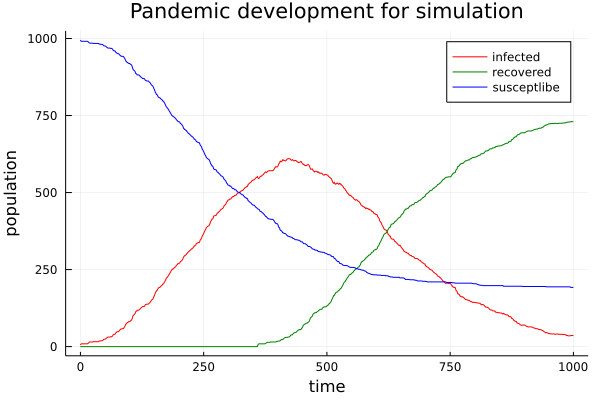

In [7]:
p1 = Plots.plot(x, agents1_df[:, aggname(:status, infected)],
    linecolor = "red",
    xlabel = "time",
    ylabel = "population",
    label = "infected",
    title = "Pandemic development for simulation")
Plots.plot!(x, agents1_df[:, aggname(:status, recovered)],
    linecolor = :green,
    label = "recovered")
Plots.plot!(x, agents1_df[:, aggname(:status, susceptlibe)],
    linecolor = :blue,
    label = "susceptlibe")

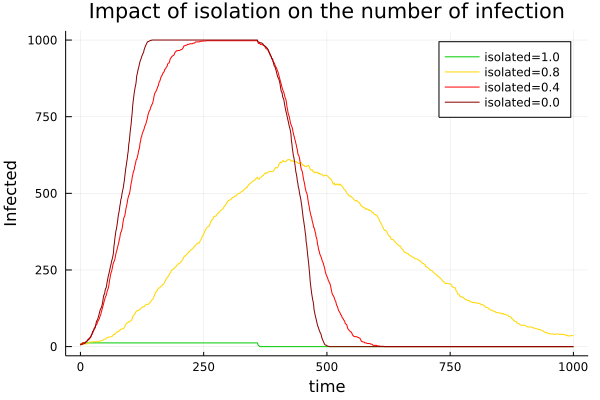

In [8]:
Plots.plot(x, agents2_df[:, aggname(:status, infected)],
    linecolor = "#00CC00",
    ylabel = "Infected",
    xlabel = "time",
    label = "isolated=1.0",
    title = "Impact of isolation on the number of infection")
Plots.plot!(x, agents1_df[:, aggname(:status, infected)],
    linecolor = "#FFD700",
    label = "isolated=0.8")
Plots.plot!(x, agents3_df[:, aggname(:status, infected)],
    linecolor = "#FF0000",
    label = "isolated=0.4")
Plots.plot!(x, agents4_df[:, aggname(:status, infected)],
    linecolor = "#8B0000",
    label = "isolated=0.0")

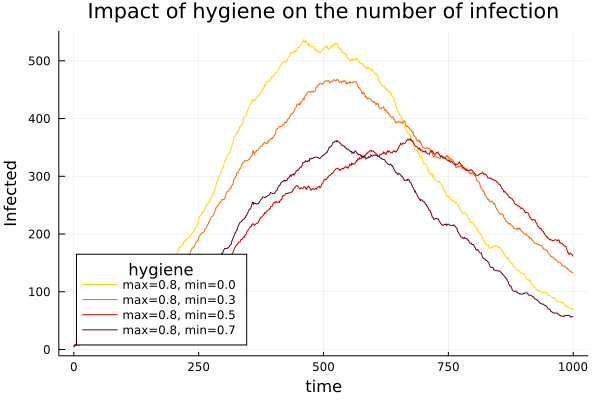

In [9]:
Plots.plot(x, agentsd[:, aggname(:status, infected)],
    linecolor = "#FFD700",
    ylabel = "Infected",
    xlabel = "time",
    label = "max=0.8, min=0.0",
    title = "Impact of hygiene on the number of infection",
    legendtitle = "hygiene",
    legend = :bottomleft)
Plots.plot!(x, agentsc[:, aggname(:status, infected)],
    linecolor = "#FF6600",
    label = "max=0.8, min=0.3")
Plots.plot!(x, agentsb[:, aggname(:status, infected)],
    linecolor = "#CC0000",
    label = "max=0.8, min=0.5")
Plots.plot!(x, agentsa[:, aggname(:status, infected)],
    linecolor = "#660033",
    label = "max=0.8, min=0.7")

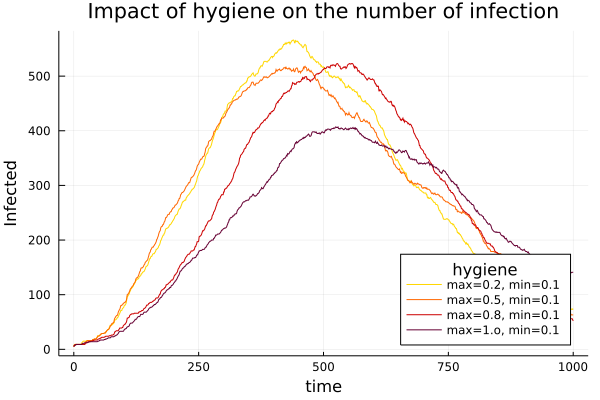

In [10]:
Plots.plot(x, agents1d[:, aggname(:status, infected)],
    linecolor = "#FFD700",
    ylabel = "Infected",
    xlabel = "time",
    label = "max=0.2, min=0.1",
    title = "Impact of hygiene on the number of infection",
    legendtitle = "hygiene",
    legend = :bottomright)
Plots.plot!(x, agents1c[:, aggname(:status, infected)],
    linecolor = "#FF6600",
    label = "max=0.5, min=0.1")
Plots.plot!(x, agents1b[:, aggname(:status, infected)],
    linecolor = "#CC0000",
    label = "max=0.8, min=0.1")
Plots.plot!(x, agents1a[:, aggname(:status, infected)],
    linecolor = "#660033",
    label = "max=1.o, min=0.1")